In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import obspy
import cartopy.crs as ccrs
import pandas as pd

In [72]:
# PLOT THE P-wave AXIAL STRAIN RADIATION-PATTERN FOR A MOMENT TENSOR m ALONG
# THE Z DIRECTION OF MEASUREMENT
#
# REFERENCE SYSTEM North-East-Down (NED)
#
# INPUT
# m:    moment tensor in cartesian coordinates arranged as a column vector
#       in the order Mxx,Mxy,Mxz,Myy,Myz,Mzz
#
# OUTPUT
# plot of the strain radiation-pattern
#
# Ismael Vera Rodriguez
# verarodr@ualberta.ca

def rad_pattern(mt):

    m = cart_mt

    # NUMBER OF POINTS TO USE IN PLOTTING
    Np = 101 # Use uneven number to have a value in the center closest to zero depth

    # SPHERICAL COORDINATE AXES - why start with spherical coordinates when we want Cartesian anyway?
    phi = np.linspace(0, 2*np.pi, 2*Np) # (0 to 360), 20 points
    theta = np.linspace(0, np.pi, Np) # (-90 to 90), 10 points

    # print(phi.shape)
    # print(theta.shape)

    # GRID COORDINATES
    theta, phi = np.meshgrid(theta, phi)

    # print(phi.shape)
    # print(theta.shape)
    # print('-----')

    # CONVERT TO CARTESIAN COORDINATES (NED)
    # r_xy = np.sin(theta)
    x = np.sin(phi) * np.sin(theta) # North
    y = np.cos(phi) * np.sin(theta) # East
    z = np.cos(theta) # Down

#     print(x.shape)
#     print(y.shape)
#     print(z.shape)
#     print('-----')

    # RADIATION PATTERN COEFFICIENTS FOR P-WAVES
    Sp = (1 - 4*z**2)*( m[0]*y**2 + 2*m[1]*x*y + m[3]*x**2 ) + (1 - 2*z**2)*( 4*m[2]*y*z + 4*m[4]*x*z ) + m[5]*(3*z**2 - 4*z**4)

    # RADIATION PATTERN COEFFICIENTS FOR S-WAVES
    Ss = -(1 - 4*z**2)*( m[0]*y**2 + 2*m[1]*x*y + m[3]*x**2 ) - (3 - 4*z**2)*( 2*m[2]*y*z + 2*m[4]*x*z ) + m[5]*( 1 - (z**2)*(5 - 4*z**2) )

    # print(Sp.shape)
    
    z0 = 0
    Sp_z0 = (1 - 4*z0**2)*( m[0]*y**2 + 2*m[1]*x*y + m[3]*x**2 ) + (1 - 2*z0**2)*( 4*m[2]*y*z0 + 4*m[4]*x*z0 ) + m[5]*(3*z0**2 - 4*z0**4)
    xP_z0 = np.abs(Sp_z0)*np.sin(theta)*np.cos(phi) # why do the equations switch? Now matches wikipedia convention
    yP_z0 = np.abs(Sp_z0)*np.sin(theta)*np.sin(phi)
    zP_z0 = np.abs(Sp_z0)*np.cos(theta)
    
    colormap = cm.seismic
    clrP_z0 = cm.ScalarMappable(norm=Normalize(vmin=Sp_z0.min(), vmax=Sp_z0.max()), cmap=colormap)
    clrP_z0 = clrP_z0.to_rgba(Sp_z0)
    
    # USE RADIATION PATTERN MAGNITUDES AS THE RADIAL COORDINATE TO PLOT THE RADIATION PATTERN
    xP = np.abs(Sp)*np.sin(theta)*np.cos(phi) # why do the equations switch? Now matches wikipedia convention
    yP = np.abs(Sp)*np.sin(theta)*np.sin(phi)
    zP = np.abs(Sp)*np.cos(theta)
    xS = np.abs(Ss)*np.sin(theta)*np.cos(phi)
    yS = np.abs(Ss)*np.sin(theta)*np.sin(phi)
    zS = np.abs(Ss)*np.cos(theta)

    # COLOR SCHEMES
    colormap = cm.seismic
    clrP = cm.ScalarMappable(norm=Normalize(vmin=Sp.min(), vmax=Sp.max()), cmap=colormap)
    clrP = clrP.to_rgba(Sp)
    clrS = cm.ScalarMappable(norm=Normalize(vmin=Ss.min(), vmax=Ss.max()), cmap=colormap)
    clrS = clrS.to_rgba(Ss)

    # PLOT LIMITS
    mx = np.max( [np.abs(Sp), np.abs(Ss)] )
    mx = [-mx, mx]

    # PLOT RADIATION PATTERNS
    fig = plt.figure(figsize = (8,3), dpi = 100)

    # 3D P-wave
    
    ax1 = fig.add_subplot(121, projection = '3d')
    ax1.plot_surface(yP, xP, zP, facecolors = clrP, cmap = cm.seismic)
    ax1.set_xlabel('Easting (Y)')
    ax1.set_ylabel('Northing (X)')
    ax1.set_zlabel('Depth (Z)')
    ax1.set_title('Strain radiation pattern\nP-wave, z-axial', fontsize = 12)
    ax1.set_xlim(mx)
    ax1.set_ylim(mx)
    ax1.set_zlim(mx)
    ax1.invert_zaxis()
    ax1.grid()
    
    plt.show()
    
#     # 3D S-wave
    
#     ax2 = fig.add_subplot(122, projection='3d')
#     ax2.plot_surface(yS, xS, zS, facecolors=clrS)
#     ax2.set_xlabel('Easting (Y)')
#     ax2.set_ylabel('Northing (X)')
#     ax2.set_zlabel('Depth (Z)')
#     ax2.set_title('Strain radiation pattern\nS-wave, z-axial', fontsize = 12)
#     ax2.set_xlim(mx)
#     ax2.set_ylim(mx)
#     ax2.set_zlim(mx)
#     ax2.invert_zaxis()
#     ax2.grid()
    
#     plt.show()
    
    # P-wave half depth slice at surface with beachball
    
    # Z = 0 slice will be in the center of each array because it's symmetrical

    z0_index = int((Np-1)/2)
    # print(z0_index)

    x_slice = xP[:, z0_index:]
    y_slice = yP[:, z0_index:]

    # print(x_slice.shape)
    # print(y_slice.shape)

    clrP = cm.ScalarMappable(norm = Normalize(vmin = Sp.min(), vmax = Sp.max()), cmap = colormap)
    flat_clrP = clrP.to_rgba(Sp[:, z0_index:])
    # print(flat_clrP.shape)

#     fig = plt.figure(figsize = (8,3), dpi = 100)
    
#     ax1 = fig.add_subplot(121)
#     bb = obspy.imaging.beachball.beach(gcmt_mt, xy = (0,0), width = 19)
#     ax1.set_xlim(-10,10)
#     ax1.set_ylim(-10,10)
#     ax1.add_collection(bb)
#     ax1.set_axis_off()
#     ax1.set_title('Focal mechanism')
    
#     ax2 = fig.add_subplot(122)

#     for i in range(len(x_slice)):
#         ax2.scatter(y_slice[i], x_slice[i], s = 0.5, alpha = 0.5, color = flat_clrP[i])

#     ax2.set_title('P-wave half depth slice at surface')
#     ax2.set_xlabel('yP (Easting)')
#     ax2.set_ylabel('xP (Northing)')

#     plt.subplots_adjust(wspace = 0.5)
#     plt.show();

    return x_slice, y_slice, flat_clrP # x, y, z, xP, yP, zP, Sp, Sp_z0, clrP, clrP_z0, xP_z0, yP_z0, zP_z0


In [73]:
# Function to convert km to degrees latitude and longitude
def km_to_lat_lon(x_km, y_km, lat0, lon0):
    """
    Convert distances in kilometers (x_km, y_km) to latitude and longitude
    based on a reference point (lat0, lon0).

    Args:
    x_km (float): Distance in kilometers in the east-west direction.
    y_km (float): Distance in kilometers in the north-south direction.
    lat0 (float): Latitude of the reference point (in degrees).
    lon0 (float): Longitude of the reference point (in degrees).

    Returns:
    (lat, lon): Tuple of latitude and longitude in degrees.
    """
    # Convert y_km to latitude change
    delta_lat = y_km / 111.0

    # Convert x_km to longitude change
    delta_lon = x_km / (111.0 * np.cos(np.radians(lat0)))

    # Calculate new latitude and longitude
    lat = lat0 + delta_lat
    lon = lon0 + delta_lon

    return lat, lon

In [74]:
bsm_mda = pd.read_csv('/Users/sydneydybing/SW4/strain/experiments/bsm_metadata.csv')
na_stas = bsm_mda.loc[(bsm_mda['LONG'] <= -110) & (bsm_mda['LONG'] >= -130)]

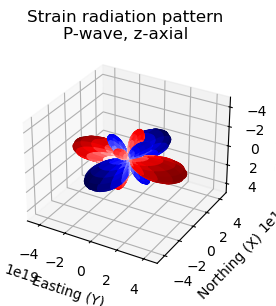

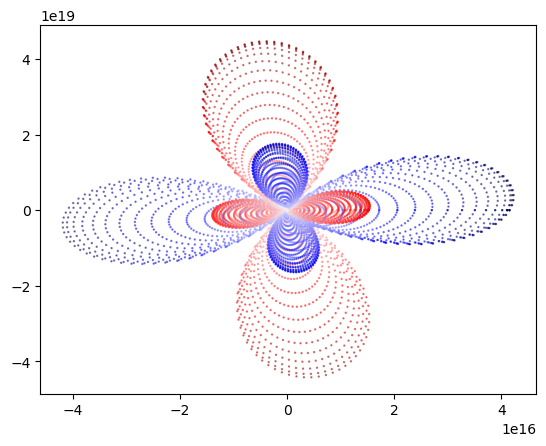

In [75]:
# Ridgecrest earthquake

# 201907060319A CENTRAL CALIFORNIA

#   Date: 2019/ 7/ 6   Centroid Time:  3:20: 5.4 GMT
#   Lat=  35.78  Lon=-117.58
#   Depth= 12.0   Half duration= 8.0
#   Centroid time minus hypocenter time: 12.4
#   Moment Tensor: Expo=26  -0.233 -4.110 4.340 0.508 0.492 0.948 
#   Mw = 7.0    mb = 0.0    Ms = 7.1   Scalar Moment = 4.39e+26
#   Fault plane:  strike=321    dip=81   slip=180
#   Fault plane:  strike=51    dip=90   slip=9

# Convert moment tensor to Cartesian
Expo = 10**(26-7) # converts to N-m from dyne-cm I think - then end up with pattern in m?

Mrr = -0.233 
Mtt = -4.110
Mpp = 4.340 
Mrt = 0.508 
Mrp = 0.492 
Mtp = 0.948

gcmt_mt = Expo * np.array((Mrr, Mtt, Mpp, Mrt, Mrp, Mtp))

Mzz = Mrr
Mxx = Mtt
Myy = Mpp
Mxz = Mrt
Myz = -Mrp
Mxy = -Mtp

cart_mt = Expo * np.array((Mxx, Mxy, Mxz, Myy, Myz, Mzz))

# Get the radiation pattern
x_slice_m, y_slice_m, flat_clrP = rad_pattern(cart_mt);
x_slice = x_slice_m/1000
y_slice = y_slice_m/1000

for i in range(len(x_slice)):
    plt.scatter(x_slice[i], y_slice_m[i], s = 0.5, alpha = 0.5, color = flat_clrP[i])

# # Convert from km (check to make sure it is this!) to degrees
# lat0 = 35.78 # Hypocenter lat
# lon0 = -117.58 # Hypocenter lon
# lat_slice, lon_slice = km_to_lat_lon(x_slice, y_slice, lat0, lon0)

# # Plot
# fig = plt.figure(figsize = (8, 8))
# ax = plt.axes(projection = ccrs.PlateCarree())

# for i in range(len(lon_slice)):
#     plt.scatter(lon_slice[i], lat_slice[i], s = 0.5, alpha = 0.5, color = flat_clrP[i])   

# # Grab station subset
# low_lon = lon0 - 3
# high_lon = lon0 + 3
# low_lat = lat0 - 3
# high_lat = lat0 + 3

# # Plot stations
# stas = na_stas.loc[(na_stas['LONG'] <= high_lon) & (na_stas['LONG'] >= low_lon) & (na_stas['LAT'] <= high_lat) & (na_stas['LAT'] >= low_lat)]
# plt.scatter(stas['LONG'], stas['LAT'], marker = '^', color = 'lime', label = 'GTSMs')
# [plt.text(i, j, f'{name}', va = 'top', ha = 'left', color = 'lime') for (i, j, name) in zip(stas['LONG']+0.1, stas['LAT'], stas['BNUM'])]

# # Label/detail map
# # plt.xlim(low_lon, high_lon)
# # plt.ylim(low_lat, high_lat)
# ax.legend(loc = 'lower left')
# ax.coastlines()
# gl = ax.gridlines(draw_labels = True)

# plt.show()

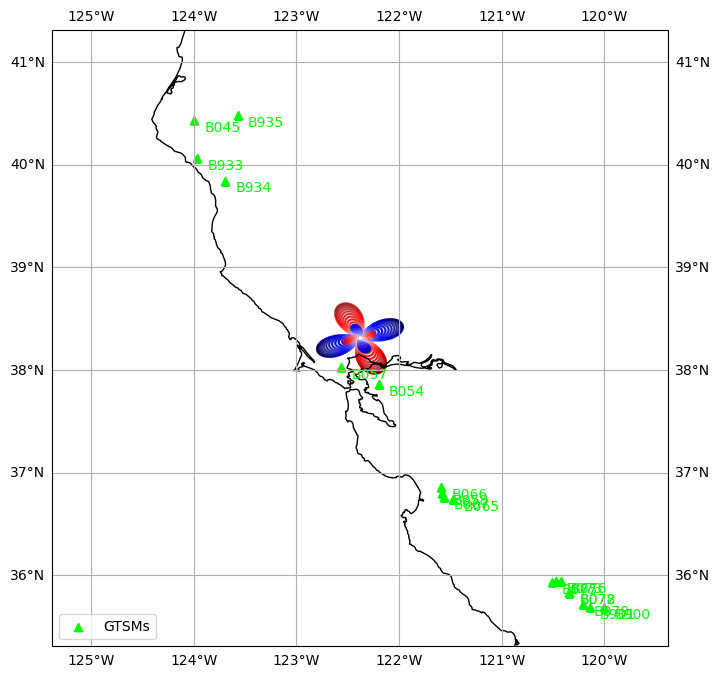

In [47]:
# 201408241020A NORTHERN CALIFORNIA 

#   Date: 2014/ 8/24   Centroid Time: 10:20:49.4 GMT
#   Lat=  38.31  Lon=-122.38
#   Depth= 12.0   Half duration= 2.6
#   Centroid time minus hypocenter time:  5.3
#   Moment Tensor: Expo=25  -0.048 -1.090 1.140 -0.136 -0.250 1.120 
#   Mw = 6.1    mb = 0.0    Ms = 6.1   Scalar Moment = 1.6e+25
#   Fault plane:  strike=157    dip=83   slip=174
#   Fault plane:  strike=248    dip=84   slip=8

eq_name = '2014-08-24_M6.02'

Expo = 25

Mrr = -0.048 * Expo
Mtt = -1.090 * Expo
Mpp = 1.140 * Expo
Mrt = -0.136 * Expo
Mrp = -0.250 * Expo
Mtp = 1.120 * Expo

gcmt_mt = np.array((Mrr, Mtt, Mpp, Mrt, Mrp, Mtp))

Mzz = Mrr
Mxx = Mtt
Myy = Mpp
Mxz = Mrt
Myz = -Mrp
Mxy = -Mtp

cart_mt = np.array((Mxx, Mxy, Mxz, Myy, Myz, Mzz))
                
# Get the radiation pattern
x_slice, y_slice, flat_clrP = rad_pattern(cart_mt);

# Convert from km (check to make sure it is this!) to degrees
lat0 = 38.31 # Hypocenter lat
lon0 = -122.38 # Hypocenter lon
lat_slice, lon_slice = km_to_lat_lon(x_slice, y_slice, lat0, lon0)

# for i in range(len(lon_slice)):
#     plt.scatter(lon_slice[i], lat_slice[i], s = 0.5, alpha = 0.5, color = flat_clrP[i])  
# plt.show()

# Plot
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = ccrs.PlateCarree())

for i in range(len(lon_slice)):
    plt.scatter(lon_slice[i], lat_slice[i], s = 0.5, alpha = 0.5, color = flat_clrP[i])   

# Grab station subset
low_lon = lon0 - 3
high_lon = lon0 + 3
low_lat = lat0 - 3
high_lat = lat0 + 3

# Plot stations
# stas = na_stas
stas = na_stas.loc[(na_stas['LONG'] <= high_lon) & (na_stas['LONG'] >= low_lon) & (na_stas['LAT'] <= high_lat) & (na_stas['LAT'] >= low_lat)]
plt.scatter(stas['LONG'], stas['LAT'], marker = '^', color = 'lime', label = 'GTSMs')
[plt.text(i, j, f'{name}', va = 'top', ha = 'left', color = 'lime') for (i, j, name) in zip(stas['LONG']+0.1, stas['LAT'], stas['BNUM'])]

# Label/detail map
plt.xlim(low_lon, high_lon)
plt.ylim(low_lat, high_lat)
ax.legend(loc = 'lower left')
ax.coastlines()
gl = ax.gridlines(draw_labels = True)

plt.show()

<>:60: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_23892/3653889258.py:60: SyntaxWarning: invalid escape sequence '\s'
  stas = pd.read_csv('/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/stations.list', delimiter = '\s+') # Stations


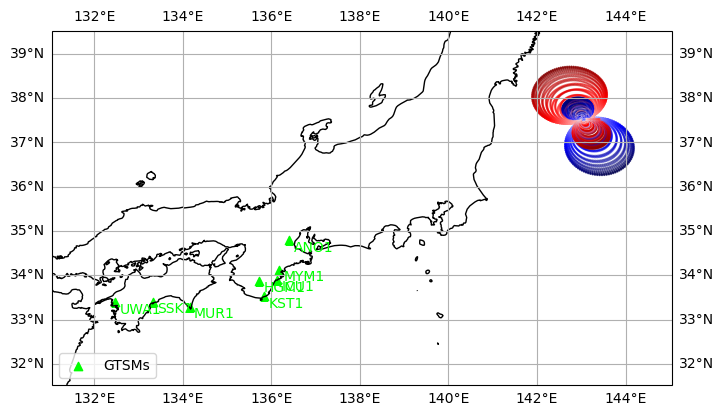

In [54]:
# Tohoku earthquake

# 201103110546A NEAR EAST COAST OF HONSH

#   Date: 2011/ 3/11   Centroid Time:  5:47:32.8 GMT
#   Lat=  37.52  Lon= 143.05
#   Depth= 20.0   Half duration=70.0
#   Centroid time minus hypocenter time: 69.8
#   Moment Tensor: Expo=29  1.730 -0.281 -1.450 2.120 4.550 -0.657 
#   Mw = 9.1    mb = 7.9    Ms = 7.9   Scalar Moment = 5.31e+29
#   Fault plane:  strike=203    dip=10   slip=88
#   Fault plane:  strike=25    dip=80   slip=90

Expo = 29

Mrr = 1.730 * Expo
Mtt = -0.281 * Expo
Mpp = -1.450 * Expo
Mrt = 2.120 * Expo
Mrp = 4.550 * Expo
Mtp = -0.657 * Expo

gcmt_mt = np.array((Mrr, Mtt, Mpp, Mrt, Mrp, Mtp))

Mzz = Mrr
Mxx = Mtt
Myy = Mpp
Mxz = Mrt
Myz = -Mrp
Mxy = -Mtp

cart_mt = np.array((Mxx, Mxy, Mxz, Myy, Myz, Mzz))
                
# Get the radiation pattern
x_slice, y_slice, flat_clrP = rad_pattern(cart_mt);

# Convert from km (check to make sure it is this!) to degrees
lat0 = 37.52 # Hypocenter lat
lon0 = 143.05 # Hypocenter lon
lat_slice, lon_slice = km_to_lat_lon(x_slice, y_slice, lat0, lon0)

# for i in range(len(lon_slice)):
#     plt.scatter(lon_slice[i], lat_slice[i], s = 0.5, alpha = 0.5, color = flat_clrP[i])  
# plt.show()

# Plot
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = ccrs.PlateCarree())

for i in range(len(lon_slice)):
    plt.scatter(lon_slice[i], lat_slice[i], s = 0.5, alpha = 0.5, color = flat_clrP[i])   

# Grab station subset
low_lon = lon0 - 12
high_lon = lon0 + 2
low_lat = lat0 - 6
high_lat = lat0 + 2

# Plot stations
stas = pd.read_csv('/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/stations.list', delimiter = '\s+') # Stations
plt.scatter(stas['longitude'], stas['latitude'], marker = '^', color = 'lime', label = 'GTSMs')
[plt.text(i, j, f'{name}', va = 'top', ha = 'left', color = 'lime') for (i, j, name) in zip(stas['longitude']+0.1, stas['latitude'], stas['Station_name'])]

# Label/detail map
plt.xlim(low_lon, high_lon)
plt.ylim(low_lat, high_lat)
ax.legend(loc = 'lower left')
ax.coastlines()
gl = ax.gridlines(draw_labels = True)

plt.show()

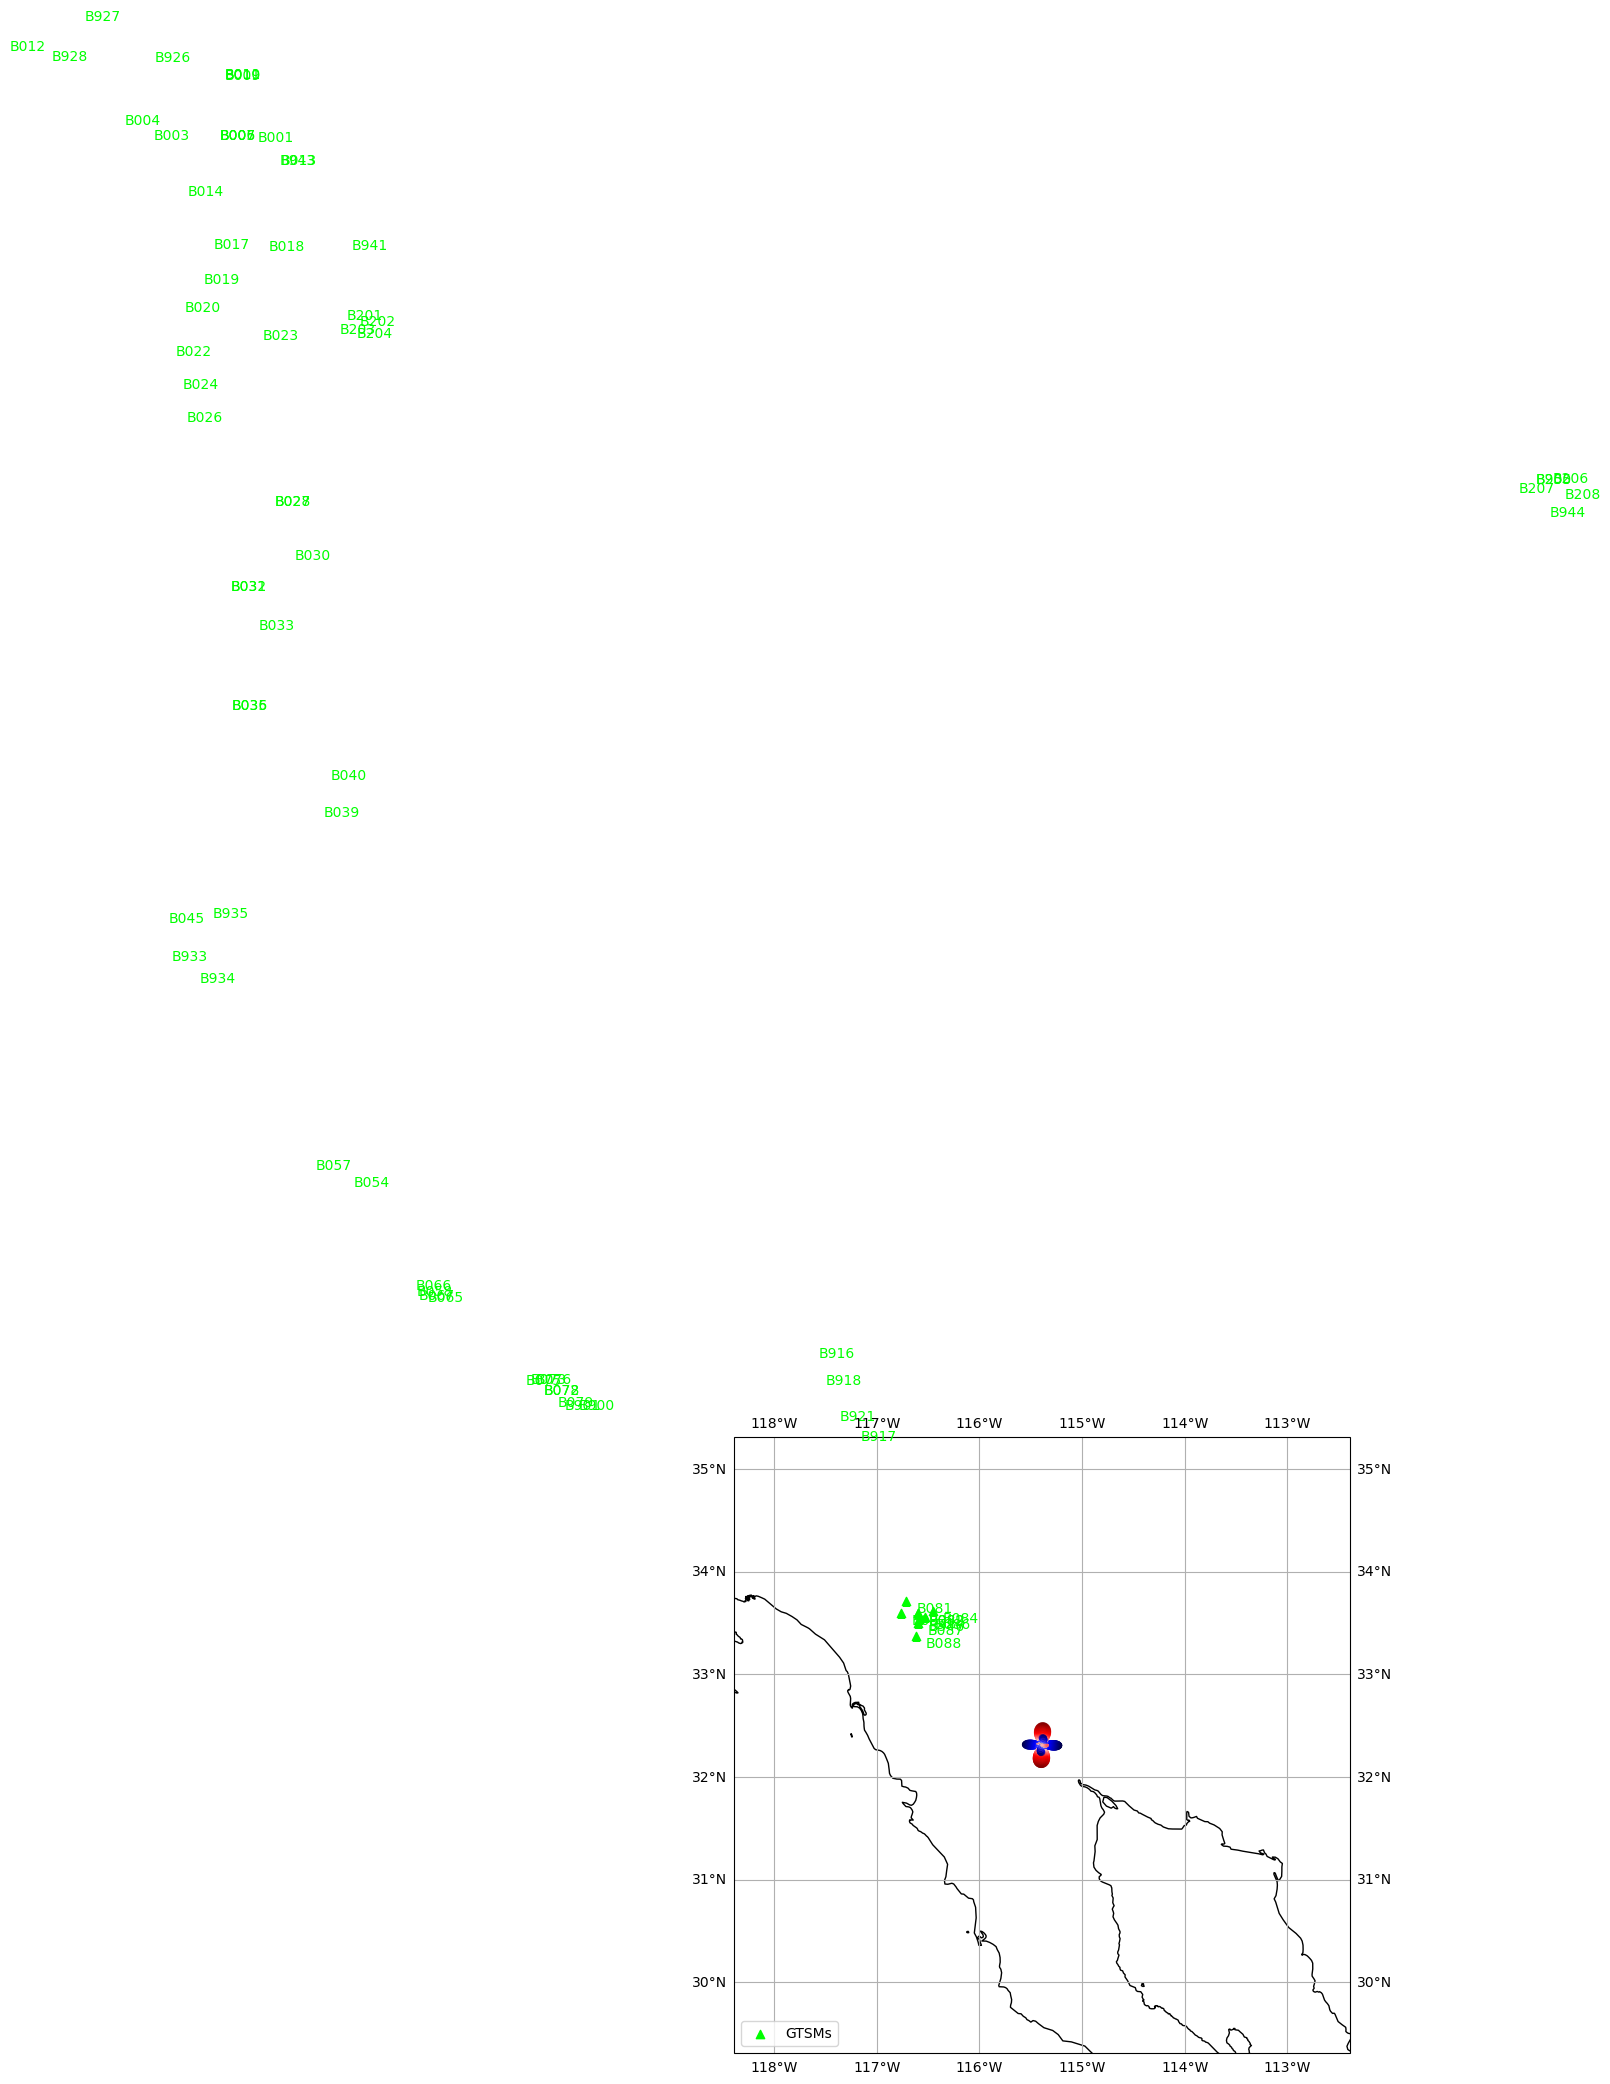

In [55]:
# Easter earthquake

# 201004042240A CALIF.-BAJA CALIF. BORDE

#   Date: 2010/ 4/ 4   Centroid Time: 22:41: 9.2 GMT
#   Lat=  32.31  Lon=-115.39
#   Depth= 12.8   Half duration= 9.6
#   Centroid time minus hypocenter time: 26.2
#   Moment Tensor: Expo=27  -0.229 -0.642 0.871 0.043 -0.057 -0.054 
#   Mw = 7.2    mb = 6.4    Ms = 7.3   Scalar Moment = 7.62e+26
#   Fault plane:  strike=223    dip=84   slip=-2
#   Fault plane:  strike=313    dip=88   slip=-174

Expo = 27

Mrr = -0.229 * Expo
Mtt = -0.642 * Expo
Mpp = 0.871 * Expo
Mrt = 0.043 * Expo
Mrp = -0.057 * Expo
Mtp = -0.054 * Expo

gcmt_mt = np.array((Mrr, Mtt, Mpp, Mrt, Mrp, Mtp))

Mzz = Mrr
Mxx = Mtt
Myy = Mpp
Mxz = Mrt
Myz = -Mrp
Mxy = -Mtp

cart_mt = np.array((Mxx, Mxy, Mxz, Myy, Myz, Mzz))
                
# Get the radiation pattern
x_slice, y_slice, flat_clrP = rad_pattern(cart_mt);

# Convert from km (check to make sure it is this!) to degrees
lat0 = 32.31 # Hypocenter lat
lon0 = -115.39 # Hypocenter lon
lat_slice, lon_slice = km_to_lat_lon(x_slice, y_slice, lat0, lon0)

# for i in range(len(lon_slice)):
#     plt.scatter(lon_slice[i], lat_slice[i], s = 0.5, alpha = 0.5, color = flat_clrP[i])  
# plt.show()

# Plot
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = ccrs.PlateCarree())

for i in range(len(lon_slice)):
    plt.scatter(lon_slice[i], lat_slice[i], s = 0.5, alpha = 0.5, color = flat_clrP[i])   

# Grab station subset
low_lon = lon0 - 3
high_lon = lon0 + 3
low_lat = lat0 - 3
high_lat = lat0 + 3

# Plot stations
stas = na_stas
# stas = na_stas.loc[(na_stas['LONG'] <= high_lon) & (na_stas['LONG'] >= low_lon) & (na_stas['LAT'] <= high_lat) & (na_stas['LAT'] >= low_lat)]
plt.scatter(stas['LONG'], stas['LAT'], marker = '^', color = 'lime', label = 'GTSMs')
[plt.text(i, j, f'{name}', va = 'top', ha = 'left', color = 'lime') for (i, j, name) in zip(stas['LONG']+0.1, stas['LAT'], stas['BNUM'])]

# Label/detail map
plt.xlim(low_lon, high_lon)
plt.ylim(low_lat, high_lat)
ax.legend(loc = 'lower left')
ax.coastlines()
gl = ax.gridlines(draw_labels = True)

plt.show()

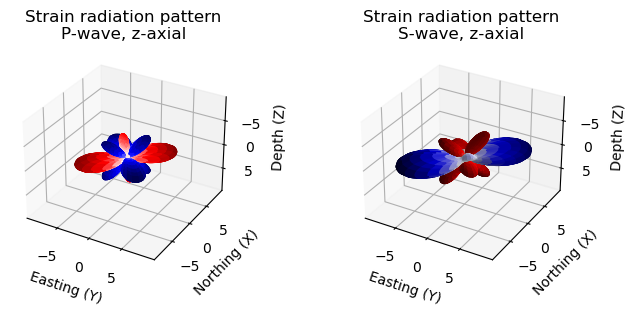

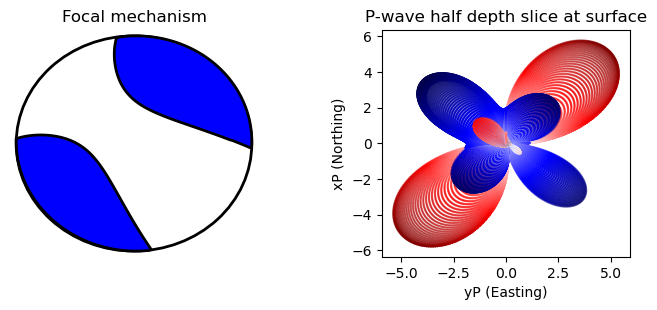

In [258]:
# Idaho earthquake

Mrr = -2.320
Mtt = 1.780 
Mpp = 0.535 
Mrt = 1.120 
Mrp = 1.150 
Mtp = -5.970 

gcmt_mt = np.array((Mrr, Mtt, Mpp, Mrt, Mrp, Mtp))

Mzz = Mrr
Mxx = Mtt
Myy = Mpp
Mxz = Mrt
Myz = -Mrp
Mxy = -Mtp

cart_mt = np.array((Mxx, Mxy, Mxz, Myy, Myz, Mzz))
                
# in the order Mxx,Mxy,Mxz,Myy,Myz,Mzz

rad_pattern(cart_mt)

In [410]:
# Offshore Cape Mendocino earthquake

eq_name = '2014-03-10_M6.8'

Mrr = -0.063
Mtt = -2.840 
Mpp = 2.900 
Mrt = 0.211 
Mrp = -0.083 
Mtp = 0.483

gcmt_mt = np.array((Mrr, Mtt, Mpp, Mrt, Mrp, Mtp))

Mzz = Mrr
Mxx = Mtt
Myy = Mpp
Mxz = Mrt
Myz = -Mrp
Mxy = -Mtp

cart_mt = np.array((Mxx, Mxy, Mxz, Myy, Myz, Mzz))
                
# in the order Mxx,Mxy,Mxz,Myy,Myz,Mzz

transp_rad_pattern(cart_mt, eq_name);

The six moment-tensor elements: Mrr, Mtt, Mpp, Mrt, Mrp, Mtp, where r
        is up, t is south, and p is east. See Aki and Richards for conversions
        to other coordinate systems. The value of each moment-tensor
	  element is followed by its estimated standard error. See note (4)
	  below for cases in which some elements are constrained in the inversion.
      
The relation to Aki and Richards x,y,z equals North,East,Down convention is as follows: 
Mrr=Mzz, Mtt=Mxx, Mpp=Myy, Mrt=Mxz, Mrp=-Myz, Mtp=-Mxy.

In [ ]:
202003312352A WESTERN IDAHO 

  Date: 2020/ 3/31   Centroid Time: 23:52:38.3 GMT
  Lat=  44.45  Lon=-115.20
  Depth= 13.8   Half duration= 4.2
  Centroid time minus hypocenter time:  7.2
  Moment Tensor: Expo=25  -2.320 1.780 0.535 1.120 1.150 -5.970 
  Mw = 6.5    mb = 0.0    Ms = 6.5   Scalar Moment = 6.39e+25
  Fault plane:  strike=174    dip=72   slip=-19
  Fault plane:  strike=270    dip=72   slip=-161

In [ ]:
201004042240A CALIF.-BAJA CALIF. BORDE

  Date: 2010/ 4/ 4   Centroid Time: 22:41: 9.2 GMT
  Lat=  32.31  Lon=-115.39
  Depth= 12.8   Half duration= 9.6
  Centroid time minus hypocenter time: 26.2
  Moment Tensor: Expo=27  -0.229 -0.642 0.871 0.043 -0.057 -0.054 
  Mw = 7.2    mb = 6.4    Ms = 7.3   Scalar Moment = 7.62e+26
  Fault plane:  strike=223    dip=84   slip=-2
  Fault plane:  strike=313    dip=88   slip=-174

In [ ]:
201403100518A OFF COAST OF NORTHERN CA

  Date: 2014/ 3/10   Centroid Time:  5:18:21.8 GMT
  Lat=  40.80  Lon=-125.23
  Depth= 15.0   Half duration= 7.0
  Centroid time minus hypocenter time:  8.4
  Moment Tensor: Expo=26  -0.063 -2.840 2.900 0.211 -0.083 0.483 
  Mw = 6.9    mb = 0.0    Ms = 6.9   Scalar Moment = 2.92e+26
  Fault plane:  strike=230    dip=86   slip=-2
  Fault plane:  strike=320    dip=88   slip=-176

In [ ]:
201103110546A NEAR EAST COAST OF HONSH

  Date: 2011/ 3/11   Centroid Time:  5:47:32.8 GMT
  Lat=  37.52  Lon= 143.05
  Depth= 20.0   Half duration=70.0
  Centroid time minus hypocenter time: 69.8
  Moment Tensor: Expo=29  1.730 -0.281 -1.450 2.120 4.550 -0.657 
  Mw = 9.1    mb = 7.9    Ms = 7.9   Scalar Moment = 5.31e+29
  Fault plane:  strike=203    dip=10   slip=88
  Fault plane:  strike=25    dip=80   slip=90

In [ ]:
202112202010A NEAR COAST OF NORTHERN C

  Date: 2021/12/20   Centroid Time: 20:10:30.9 GMT
  Lat=  40.36  Lon=-124.41
  Depth= 29.2   Half duration= 3.1
  Centroid time minus hypocenter time:  0.5
  Moment Tensor: Expo=25  0.184 -2.070 1.890 0.030 -0.748 -1.510 
  Mw = 6.2    mb = 0.0    Ms = 6.2   Scalar Moment = 2.6e+25
  Fault plane:  strike=115    dip=75   slip=171
  Fault plane:  strike=207    dip=82   slip=15

In [411]:
# Offshore Cape Mendocino earthquake

eq_name = '2021-12-20_M6.2'

Mrr = 0.184
Mtt = -2.070 
Mpp = 1.890 
Mrt = 0.030 
Mrp = -0.748 
Mtp = -1.510

gcmt_mt = np.array((Mrr, Mtt, Mpp, Mrt, Mrp, Mtp))

Mzz = Mrr
Mxx = Mtt
Myy = Mpp
Mxz = Mrt
Myz = -Mrp
Mxy = -Mtp

cart_mt = np.array((Mxx, Mxy, Mxz, Myy, Myz, Mzz))
                
# in the order Mxx,Mxy,Mxz,Myy,Myz,Mzz

transp_rad_pattern(cart_mt, eq_name);

In [ ]:
202212201034A NEAR COAST OF NORTHERN C

  Date: 2022/12/20   Centroid Time: 10:34:32.0 GMT
  Lat=  40.62  Lon=-124.25
  Depth= 17.0   Half duration= 3.7
  Centroid time minus hypocenter time:  7.8
  Moment Tensor: Expo=25  0.165 -2.820 2.650 -0.246 -0.370 3.400 
  Mw = 6.4    mb = 0.0    Ms = 6.4   Scalar Moment = 4.39e+25
  Fault plane:  strike=160    dip=85   slip=176
  Fault plane:  strike=251    dip=86   slip=5


In [412]:
# Offshore Cape Mendocino earthquake

eq_name = '2022-12-20_M6.4'

Mrr = 0.165
Mtt = -2.820 
Mpp = 2.650 
Mrt = -0.246 
Mrp = -0.370 
Mtp = 3.400

gcmt_mt = np.array((Mrr, Mtt, Mpp, Mrt, Mrp, Mtp))

Mzz = Mrr
Mxx = Mtt
Myy = Mpp
Mxz = Mrt
Myz = -Mrp
Mxy = -Mtp

cart_mt = np.array((Mxx, Mxy, Mxz, Myy, Myz, Mzz))
                
# in the order Mxx,Mxy,Mxz,Myy,Myz,Mzz

transp_rad_pattern(cart_mt, eq_name);

In [ ]:
201408241020A NORTHERN CALIFORNIA 

  Date: 2014/ 8/24   Centroid Time: 10:20:49.4 GMT
  Lat=  38.31  Lon=-122.38
  Depth= 12.0   Half duration= 2.6
  Centroid time minus hypocenter time:  5.3
  Moment Tensor: Expo=25  -0.048 -1.090 1.140 -0.136 -0.250 1.120 
  Mw = 6.1    mb = 0.0    Ms = 6.1   Scalar Moment = 1.6e+25
  Fault plane:  strike=157    dip=83   slip=174
  Fault plane:  strike=248    dip=84   slip=8

In [415]:
# Offshore Cape Mendocino earthquake

eq_name = '2014-08-24_M6.02'

Mrr = -0.048
Mtt = -1.090 
Mpp = 1.140 
Mrt = -0.136 
Mrp = -0.250
Mtp = 1.120

gcmt_mt = np.array((Mrr, Mtt, Mpp, Mrt, Mrp, Mtp))

Mzz = Mrr
Mxx = Mtt
Myy = Mpp
Mxz = Mrt
Myz = -Mrp
Mxy = -Mtp

cart_mt = np.array((Mxx, Mxy, Mxz, Myy, Myz, Mzz))
                
# in the order Mxx,Mxy,Mxz,Myy,Myz,Mzz

transp_rad_pattern(cart_mt, eq_name);

In [416]:
# Ridgecrest earthquake

eq_name = '2019-07-06_M7.1'

Mrr = -0.455 
Mtt = -5.680 
Mpp = 6.130 
Mrt = -0.004 
Mrp = -0.564 
Mtp = 0.487 

gcmt_mt = np.array((Mrr, Mtt, Mpp, Mrt, Mrp, Mtp))

Mzz = Mrr
Mxx = Mtt
Myy = Mpp
Mxz = Mrt
Myz = -Mrp
Mxy = -Mtp

cart_mt = np.array((Mxx, Mxy, Mxz, Myy, Myz, Mzz))
                
# in the order Mxx,Mxy,Mxz,Myy,Myz,Mzz

transp_rad_pattern(cart_mt, eq_name);